<a href="https://colab.research.google.com/github/yuva-01997656/cs480student/blob/main/CS480_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

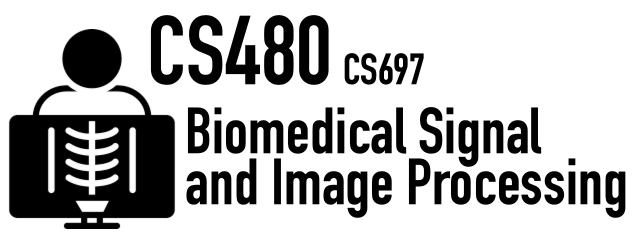
#Assignment 6

In [ ]:
# In this assignment, we will train a U-Net classifer to detect mitochondria
# in electron microscopy images!

In [ ]:
### IMPORTANT ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [ ]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-7rp2vio1
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-7rp2vio1


In [ ]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!
import unet

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

In [ ]:
# The unet package allows to train a U-Net classifier with little code.
# As discussed in class, the U-Net can be used to label/segment/annotate images.

In [ ]:
# TODO: Please study the Circles example 
# https://github.com/jakeret/unet/blob/master/notebooks/circles.ipynb

In [ ]:
# TODO: ... and look how the (artificial) dataset is generated
# https://github.com/jakeret/unet/blob/master/src/unet/datasets/circles.py

In [ ]:
# 1) Question
# TODO: Please describe what the U-Net is trained to do.
#
# TODO: 

Unet is trained to recognize circles of noisy image data and this data is not  filtered.

In [ ]:
# 2) Question
# TODO: In circles.py, what does the following mean:
#     channels = 1
#     classes = 2
#
# TODO: 

Channel parameters provide information about the data layer. Since the value is 1, I think the image we have is grayscale. Class specifications are represented by class parameters. The two class specifications do not have to be circles

In [ ]:
# 3) Question
# TODO: What are mitochondria and what is their appearance in
# electron microscopy data?
# Hint: You can validate your answer in Task 4!
#
# TODO: YOUR ANSWER

*Mitochondria is referred to be the cell's powerhouse. When viewed under an electron microscope, mitochondria appear as spherical or sausage-shaped structures.*

**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [ ]:
# TODO: 
# Download https://cs480.org/data/mito.npz to your computer.
# Then, please upload mito.npz using the file panel on the left.

In [ ]:
# The code below is similar to the circles.py file from Task 1.
# We follow Tensorflow conventions to design a tf.data.Dataset for training
# the U-Net.
#
# TODO: Please add four different data augmentation methods in the code block
# below. (image normalization to 0..1, horizontal data flip, vertical data flip,
# rotation by 90 degrees)
#
# Hint: https://github.com/jakeret/unet/blob/master/src/unet/datasets/oxford_iiit_pet.py#L25

In [ ]:
import numpy as np

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List
import numpy as np

IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    loaded = np.load('/content/drive/MyDrive/US Assignments/mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        #
        # TODO: Normalize the image to 0..1
        #
        # TODO: YOUR CODE
        # Tensorflow is used to load the image, which is then divided by 255.0 to normalise it.
        image = tf.cast(image, tf.float32) / 255.0
        # decrementing the mask with 1 unit
        mask -= 1
        #
        # TODO: Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
          
            #
            # TODO: YOUR CODE
            # To flip the image left to right 
            image = tf.image.flip_left_right(image)
            # TO flip the mask left to right
            mask = tf.image.flip_left_right(mask)

        #
        # TODO: Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            # To FLip the image vertically
            image = tf.image.flip_up_down(image)
            # To FLip the mask vertically
            mask = tf.image.flip_up_down(mask)

        #
        # TODO: Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            # To Rotate image by 90 degrees
            image = tf.image.rot90(image)
            # To Rotate mask by 90 degrees
            mask = tf.image.rot90(mask)


        # augmentation done, let's store the image
        images[i] = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

    return images, labels

**Task 3**: Let's train the U-Net! [25 Points]

In [ ]:
#
# We can now create our training, validation, and testing data by calling
# our methods from Task 2.
#
train,val,test = load_data(660,splits=(0.7, 0.2, 0.1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: DeprecationWarning: `np.bool` is a deprecated alias for the bu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1) Question
# TODO: We have in total 660 images + 660 masks. Based on the code above,
# how many images are used for training alone?
#
# TODO: YOUR ANSWER

In [ ]:
#
# Let's setup the U-Net!
#
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [ ]:
#
# And, let's setup the trainer...
#
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [ ]:
#
# ...and train the U-Net for 50 epochs with a batch_size of 10!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use training and validation data.
# Hint 2: This will take roughly 30 minutes!
#
trainer.fit(unet_model,
            #
            # TODO: YOUR CODE
            train, 
            val, 
            epochs = 15, 
            batch_size= 10
            #
            #
              )

Epoch 1/15
47/47 [==============================] - 94s 2s/step - loss: 0.2379 - categorical_crossentropy: 0.2379 - categorical_accuracy: 0.8322 - mean_iou: 0.3697 - dice_coefficient: 0.7591 - auc: 0.9516 - learning_rate: 3.3542e-04 - val_loss: 0.1198 - val_categorical_crossentropy: 0.1198 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.4188 - val_dice_coefficient: 0.8548 - val_auc: 0.9936
Epoch 2/15
47/47 [==============================] - 70s 1s/step - loss: 0.0921 - categorical_crossentropy: 0.0921 - categorical_accuracy: 0.9115 - mean_iou: 0.4200 - dice_coefficient: 0.8660 - auc: 0.9764 - learning_rate: 9.0805e-04 - val_loss: 0.0250 - val_categorical_crossentropy: 0.0250 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.4596 - val_dice_coefficient: 0.9442 - val_auc: 0.9937
Epoch 3/15
47/47 [==============================] - 69s 1s/step - loss: 0.0832 - categorical_crossentropy: 0.0832 - categorical_accuracy: 0.9115 - mean_iou: 0.4244 - dice_coefficient: 0.8743 - auc: 0.9804

**Task 4**: Let's predict mitochondria in the testing data! [15 Points]

In [ ]:
# 
# After training, let's try the U-Net on our testing data.
#
# The code below displays the first 10 input images, the original masks by experts, 
# and the predicted masks from the U-Net.

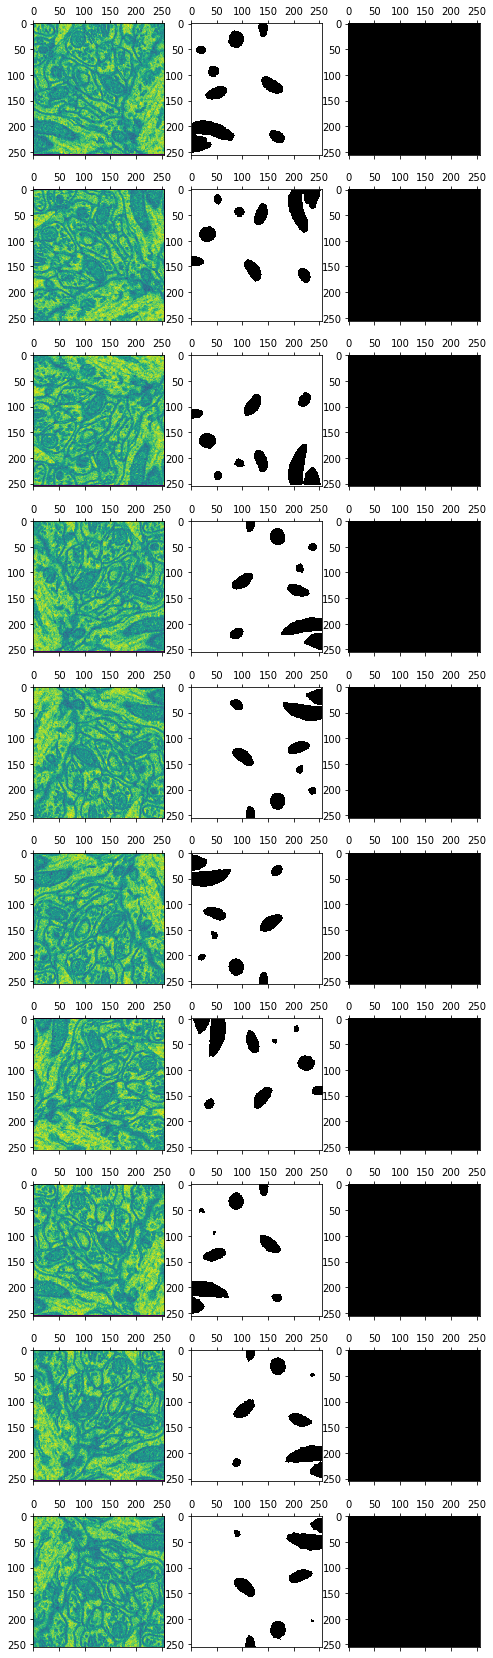

In [ ]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

In [ ]:
# 1) Question
# TODO: Why do we use the prediction[0].argmax(axis=-1) command
# to display the prediction?
# 
# TODO: YOUR ANSWER

Prediction [0] is used to get the shape of the first predicted image 
 
 on the other hand 
 
 .argmax (axis = 1) is used to get the actual shape of the image

In [ ]:
# 2) Question
# TODO: Is the quality of the segmentation good and how could we improve it?
# Hint: Think along the lines of some traditional image processing rather than
# increasing the training data size.
#
# TODO: YOUR ANSWER

The quality of the segmentation is noteworthy. 
 
 Although it can be improved by removing noise and some advanced pretreatment techniques.

**Bonus**: Compare against the state-of-the-art literature! [33 Points]

In [ ]:
#
# The following paper also uses a 2D U-Net to detect mitochondria:
# 
# https://danielhaehn.com/papers/?casser2020fast
#

In [ ]:
# 1) Question
#
# TODO: How many learnable parameters does your trained unet_model have?
# Hint: You can use TF's Model Summary function to answer this.
#

In [ ]:
# TO get the number of learning parameters 
unet_model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv_block (ConvBlock)         (None, None, None,   37568       ['inputs[0][0]']                 
                                64)                                                               
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, None, None,   0           ['conv_block[0][0]']             
                                64)                                                            

Inorder to obtain total number of learning parameters, I used the function summary. 

The total learning parameters = 31,030,658

In [ ]:
# TODO: YOUR CODE

In [ ]:
# 2) Question
#
# TODO: How many parameters do Casser et al. use?
#

In [ ]:
# TODO: YOUR ANSWER

Casser et al. We used 1,178,480 encoder parameters, 780,053 decode parameters, and  a total of 1,958,533 total parameters.

In [ ]:
# 3) Question
#
# TODO: How did Casser et al. reduce the parameters?
#

In [ ]:
# TODO: YOUR ANSWER

Casser et al. We have reduced the parameters in various ways. The first method reduces the number of convolution filters in the network, the second method replaces the transposed convolutions of the decoder with a lighter bilinear upsampling layer, and finally replaces the original ucenter cropping network with padding. High density output  at full resolution.

In [ ]:
# 4) Question
#
# TODO: Why did Casser et al. reduce the parameters?
#

In [ ]:
# TODO: YOUR ANSWER

Casser et al. decreased the quantity of parameters to make the preprocessing faster.

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#